# ディープラーニングの実装基礎
1. ディープラーニングフレームワークの１つであるKerasの簡単な使い方を学んでみよう
1. パラメータをチューニングして、予測精度の変化を確認しよう
1. Data Augmentationを追加して、更に予測精度を改善してみよう

### おまじない

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from skimage import io

### マスタデータを読み込んでみよう
- 今回は[【練習問題】画像ラベリング（10種類）コンペ](https://signate.jp/competitions/133#abstract)に挑戦します
- まずは画像データのラベルデータである`train_master.tsv`と`label_master.tsv`及び応募用サンプルファイル`sample_submit.tsv`を読み込みます

In [2]:
labels = pd.read_csv("train_master.tsv", sep="\t")
master = pd.read_csv("label_master.tsv", sep="\t")
sample = pd.read_csv("sample_submit.tsv", header=None, sep="\t")
print(labels.shape)
print(master.shape)
print(sample.shape)

(5000, 2)
(10, 2)
(8000, 2)


### マスタデータの中身を確認してみよう

In [3]:
labels.head()

,file_name,label_id
0,train_0.jpg,1
1,train_1.jpg,5
2,train_2.jpg,1
3,train_3.jpg,6
4,train_4.jpg,3


In [4]:
master

,label_id,label_name
0,0,airplane
1,1,bird
2,2,car
3,3,cat
4,4,deer
5,5,dog
6,6,horse
7,7,monkey
8,8,ship
9,9,truck


In [5]:
sample.head()

,0,1
0,test_0.jpg,3
1,test_1.jpg,8
2,test_2.jpg,3
3,test_3.jpg,3
4,test_4.jpg,2


### 画像データを読み込んでみよう
- `train_images`フォルダと`test_images`フォルダの中にある画像を全て読み込みましょう
- ファイルの読み込む順番に気を付けましょう
    - 何も考えずにos.listdir関数等で全てのファイル名を取ってきてから読み込むとlabelsデータの順番と不整合になります
        - e.g) train_0.jpg, train_1.jpg, train_10.jpg, train_100.jpg ...
    - その為、train_imagesからはlabelsデータから1行ずつファイル名（file_name）を取り出しながら読み込みを行います
    - test_imagesも同様な理由で、sampleデータから1行ずつファイル名を取り出しながら読み込みを行います
- 読み込んだ画像はそれぞれ`train_imgs`と`test_imgs`という変数に代入し、データ型はnumpyのarrayに変換しておきましょう

In [6]:
train_imgs = []
for fname in labels["file_name"]:
    path = "./train_images/" + fname
    img = io.imread(path)
    train_imgs.append(img)
print(type(train_imgs))
train_imgs = np.array(train_imgs)
print(type(train_imgs), train_imgs.shape)

<class 'list'>
<class 'numpy.ndarray'> (5000, 96, 96, 3)


In [7]:
test_imgs = []
for fname in sample[0]:
    path = "./test_images/" + fname
    img = io.imread(path)
    test_imgs.append(img)
print(type(test_imgs))
test_imgs = np.array(test_imgs)
print(type(test_imgs), test_imgs.shape)

<class 'list'>
<class 'numpy.ndarray'> (8000, 96, 96, 3)


### 読み込んだ画像を可視化してみよう
- 2行5列で読み込んだ画像を表示させましょう
- 各画像のtitleには画像に付与されたラベルを付けます
    - 手順としては変数labelsからi行目のlabel_idを取り出し、変数masterからlabel_idが一致するlabel_nameを取得します

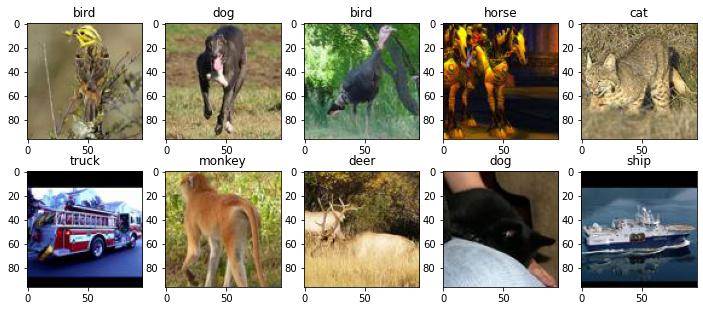

In [8]:
plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    target_id = labels.loc[i,"label_id"] # target画像のlabel_idを取得
    label = master[master["label_id"]==target_id]["label_name"].values[0] # masterからlabel_idに対応するlabel_nameを取得
    plt.title(label)
    plt.imshow(train_imgs[i])

### ラベルの分布を確認しておきましょう

In [9]:
labels["label_id"].value_counts()

7    500
3    500
6    500
2    500
9    500
5    500
1    500
8    500
4    500
0    500
Name: label_id, dtype: int64

### 画像データの画素値を正規化しておきましょう
- DeepLearningで画像を学習させる前準備として画素値を正規化しておきましょう
- 現在は画素値の値域が0~255である為、0~1となるように正規化をしておきます
- 正規化をすることで、DeepLearningの学習を円滑に行う効果を期待できます

In [10]:
train_imgs

array([[[[146, 141, 109],
         [147, 142, 110],
         [148, 143, 111],
         ...,
         [166, 160, 126],
         [165, 159, 125],
         [164, 158, 124]],

        [[146, 141, 109],
         [146, 141, 109],
         [147, 142, 110],
         ...,
         [166, 160, 126],
         [165, 159, 125],
         [164, 158, 124]],

        [[146, 141, 109],
         [146, 141, 109],
         [147, 142, 110],
         ...,
         [165, 159, 125],
         [164, 158, 124],
         [164, 158, 124]],

        ...,

        [[131, 115,  81],
         [128, 112,  78],
         [120, 104,  70],
         ...,
         [141, 124, 104],
         [151, 134, 116],
         [151, 134, 118]],

        [[140, 124,  90],
         [124, 108,  74],
         [118, 102,  68],
         ...,
         [149, 132, 114],
         [142, 125, 109],
         [131, 113,  99]],

        [[139, 123,  89],
         [112,  96,  62],
         [109,  93,  59],
         ...,
         [149, 132, 114],
        

In [11]:
train_imgs = train_imgs / 255
test_imgs = test_imgs / 255

In [12]:
train_imgs

array([[[[0.57254902, 0.55294118, 0.42745098],
         [0.57647059, 0.55686275, 0.43137255],
         [0.58039216, 0.56078431, 0.43529412],
         ...,
         [0.65098039, 0.62745098, 0.49411765],
         [0.64705882, 0.62352941, 0.49019608],
         [0.64313725, 0.61960784, 0.48627451]],

        [[0.57254902, 0.55294118, 0.42745098],
         [0.57254902, 0.55294118, 0.42745098],
         [0.57647059, 0.55686275, 0.43137255],
         ...,
         [0.65098039, 0.62745098, 0.49411765],
         [0.64705882, 0.62352941, 0.49019608],
         [0.64313725, 0.61960784, 0.48627451]],

        [[0.57254902, 0.55294118, 0.42745098],
         [0.57254902, 0.55294118, 0.42745098],
         [0.57647059, 0.55686275, 0.43137255],
         ...,
         [0.64705882, 0.62352941, 0.49019608],
         [0.64313725, 0.61960784, 0.48627451],
         [0.64313725, 0.61960784, 0.48627451]],

        ...,

        [[0.51372549, 0.45098039, 0.31764706],
         [0.50196078, 0.43921569, 0.30588235]

### 目的変数であるラベルデータをone-hot-encodingしておきましょう
- 今回は画像に付与される10種類のラベルを予測する問題です
- この場合、モデルの出力は各ラベルに対する確率値となります
    - output = [label1の確率, label2の確率, label3の確率, ..., label10の確率]
- その為、学習データもこの形に合わせる必要がある為、ラベルデータをone-hot-encodingしましょう
    - e.g) label2の場合は[0,1,0,0,0,0,0,0,0,0]とする
- one-hot-encodingはkerasのutil.to_categorical関数が便利なので、こちらを利用します

In [13]:
y = labels["label_id"]
y.head()

0    1
1    5
2    1
3    6
4    3
Name: label_id, dtype: int64

In [14]:
from keras import utils
from keras.utils import np_utils # Update 2024/03/18: Newer versions of keras==2.4.0 and tensorflow==2.3.0 would work as follows so use: from keras.utils import np_utils
y_categorical = np_utils.to_categorical(y)

In [15]:
y_categorical

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 学習パラメータの評価の為に、学習データを２つに分割しましょう
- モデルのパラメータをチューニングする際には、学習データを構築/検証データに分割するという方策をとります
- 構築データでモデルを学習し、学習に利用しなかった検証データを未知データとし、モデルの汎化性能を評価します
- numpyではnp.split関数を使うことで、簡単にデータを分割することができます
- 具体的には、`np.split(元の配列, [何番目で分割するかの数値])`と記述します
    - より詳しくは例えば[こちら](https://note.nkmk.me/python-numpy-split/)を参考にして下さい

In [16]:
np.split([1,2,3,4,5],[3])

[array([1, 2, 3]), array([4, 5])]

- 今回は学習データ5000枚中、4000枚を構築データ、残り1000枚を検証データとします
- 構築用画像を`X_tr`、検証用画像を`X_val`としましょう
- 同様に、構築用画像のラベルを`y_tr`、検証用画像のラベルを`y_val`としましょう

In [17]:
X_tr, X_val = np.split(train_imgs,[4000])
y_tr, y_val = np.split(y_categorical, [4000])

In [18]:
print(X_tr.shape, X_val.shape)
print(y_tr.shape, y_val.shape)

(4000, 96, 96, 3) (1000, 96, 96, 3)
(4000, 10) (1000, 10)


### Kerasの使い方の基本を学びましょう
- 基本となる使い方は下記となります
    1. `model = Sequential()`：モデルの箱を準備する
    1. `model.add(XXX)`：add関数の中にモジュールを記述することで、Neural Networkの構造を追加していく
    1. `model.compile(loss="xxx", optimizer="yyy", metrics=["zzz"])`：損失関数やオプティマイザー、評価関数等を設定
    1. `model.fit(trainX, y, batch_size, epoch, verbose=1, validation_data=(X_val, y_val))`：学習データやbatch_size, epoch等を設定して学習


- 今回利用するモジュールは下記です
    - Dense(X)：全結合層であり、Xはノード数を表す
    - Conv2D（filters=X, kernel_size=(x,x), padding）：畳み込み層であり、Xはフィルタの数、(x,x)はフィルタの大きさを表す
    - MaxPooling2D(pool_size=(x,x))：プーリング（max pooling）層であり、(x,x)はプーリング窓の大きさを表す
    - Activation("xxx")：活性化関数を表し、xxxに活性化関数（sigmoidやrelu）の前を記述する
    - Flatten()：多次元配列を1次元配列に変換する。畳み込み層から全結合層へ接続する際に必要となる

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers #"from tensorflow.keras import optimizers" instead of "from keras import optimizers"

### 練習で下記構造をKerasで作ってみましょう
- Sequentialを使い、モデルの箱を準備し、モデルに層を追加してみましょう

<img src="MLP.png" width="300">

In [20]:
model = Sequential()
model.add(Dense(10, input_shape=(51,)))
model.add(Activation("tanh"))
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                520       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 641
Trainable params: 641
Non-trainable params: 0
__________________________________________________________

### CNNを使って実際に学習をしてみよう

- model作成部分

In [22]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3,3), padding="same", input_shape=(96,96,3)))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same"))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=120))
model.add(Activation("sigmoid"))
model.add(Dense(units=60))
model.add(Activation("sigmoid"))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 6)         168       
_________________________________________________________________
activation_3 (Activation)    (None, 96, 96, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 12)        660       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 12)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 12)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6912)             

- 学習に必要となる損失関数やオプティマイザーと、学習結果の確認の為の評価関数の設定
    - SGDの細かいパラメータ詳細については[こちら](https://keras.io/ja/optimizers/)
    - lr（学習率）が特に重要なパラメータです

In [24]:
model.compile(loss="categorical_crossentropy",
                # optimizer=optimizers.SGD(lr=0.5, momentum=0.9, decay=0.0, nesterov=True),
                optimizer=optimizers.SGD(learning_rate=0.5, momentum=0.9, decay=0.0, nesterov=True), #"learning_rate" instead of "lr" 
                metrics=["accuracy"])

- batch_sizeとepochの設定

In [25]:
batch_size=100
epochs=10

- モデルの学習

In [26]:
history = model.fit(X_tr, y_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/10
40/40 [==============================] - 9s 207ms/step - loss: 2.3771 - accuracy: 0.0983 - val_loss: 2.3126 - val_accuracy: 0.0940
Epoch 2/10
40/40 [==============================] - 7s 180ms/step - loss: 2.3111 - accuracy: 0.0988 - val_loss: 2.3053 - val_accuracy: 0.1030
Epoch 3/10
40/40 [==============================] - 7s 168ms/step - loss: 2.3111 - accuracy: 0.0980 - val_loss: 2.3141 - val_accuracy: 0.0880
Epoch 4/10
40/40 [==============================] - 7s 166ms/step - loss: 2.3117 - accuracy: 0.0988 - val_loss: 2.3185 - val_accuracy: 0.0970
Epoch 5/10
40/40 [==============================] - 7s 169ms/step - loss: 2.3124 - accuracy: 0.0990 - val_loss: 2.3228 - val_accuracy: 0.0880
Epoch 6/10
40/40 [==============================] - 7s 178ms/step - loss: 2.3117 - accuracy: 0.0955 - val_loss: 2.3069 - val_accuracy: 0.1050
Epoch 7/10
40/40 [==============================] - 8s 195ms/step - loss: 2.3134 - accuracy: 0.0978 - val_loss: 2.3100 - val_accuracy: 0.0880
Epoch 

### 学習曲線の可視化してみよう
- 損失関数と評価関数の遷移を見ることで、モデルの学習が進んでいるのかや、過学習していないかを確認することができます

In [27]:
def learning_plot(history, epochs):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(range(1,epochs+1), history.history['loss'])
    plt.plot(range(1,epochs+1), history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.xticks(range(1,epochs+1))
    plt.ylabel('loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(range(1,epochs+1), history.history['accuracy']) #"accuracy" instead of "acc"
    plt.plot(range(1,epochs+1), history.history['val_accuracy']) #"val_accuracy" instead of "val_acc"
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.xticks(range(1,epochs+1))
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

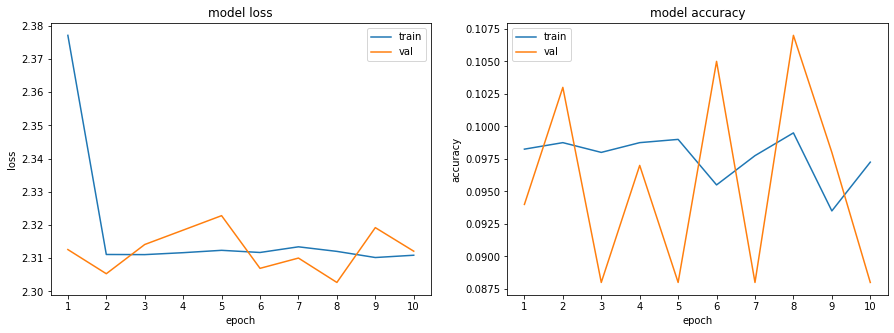

In [28]:
learning_plot(history,epochs)
# 基本的には左側の損失関数を確認すること。”train”及び”val”がしっかりと継続して減少しているかどうかを確認すること。

### 学習率を0.05にして再度モデルを学習し直してみよう
- 学習が進んでいないのは学習率が高すぎる可能性があります

In [29]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3,3), padding="same", input_shape=(96,96,3)))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same"))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=120))
model.add(Activation("sigmoid"))
model.add(Dense(units=60))
model.add(Activation("sigmoid"))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [30]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=0.05, momentum=0.9, decay=0.0, nesterov=True),
             metrics=["accuracy"])

In [31]:
batch_size=100
epochs=20

In [32]:
history = model.fit(X_tr, y_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/20
40/40 [==============================] - 9s 216ms/step - loss: 2.3307 - accuracy: 0.0990 - val_loss: 2.3135 - val_accuracy: 0.0980
Epoch 2/20
40/40 [==============================] - 8s 212ms/step - loss: 2.3162 - accuracy: 0.0905 - val_loss: 2.3094 - val_accuracy: 0.1070
Epoch 3/20
40/40 [==============================] - 9s 215ms/step - loss: 2.3137 - accuracy: 0.0965 - val_loss: 2.3101 - val_accuracy: 0.0940
Epoch 4/20
40/40 [==============================] - 9s 218ms/step - loss: 2.3136 - accuracy: 0.0983 - val_loss: 2.3054 - val_accuracy: 0.1050
Epoch 5/20
40/40 [==============================] - 9s 224ms/step - loss: 2.3099 - accuracy: 0.1002 - val_loss: 2.3135 - val_accuracy: 0.1050
Epoch 6/20
40/40 [==============================] - 9s 238ms/step - loss: 2.3106 - accuracy: 0.0955 - val_loss: 2.3071 - val_accuracy: 0.1030
Epoch 7/20
40/40 [==============================] - 9s 219ms/step - loss: 2.3109 - accuracy: 0.0975 - val_loss: 2.3050 - val_accuracy: 0.1050
Epoch 

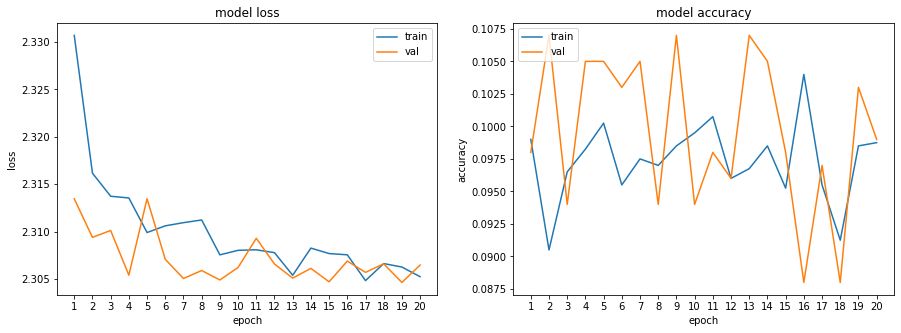

In [33]:
learning_plot(history,epochs)

### 演習①　活性化関数をsigmoidからreluに変換し、学習をし直してみましょう

In [34]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3,3), padding="same", input_shape=(96,96,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=120))
model.add(Activation("relu"))
model.add(Dense(units=60))
model.add(Activation("relu"))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [35]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=0.05, momentum=0.9, decay=0.0, nesterov=True),
             metrics=["accuracy"])

In [36]:
batch_size=100
epochs=20

In [37]:
history = model.fit(X_tr, y_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/20
40/40 [==============================] - 10s 234ms/step - loss: 2.1746 - accuracy: 0.1645 - val_loss: 2.0536 - val_accuracy: 0.2120
Epoch 2/20
40/40 [==============================] - 10s 255ms/step - loss: 1.9309 - accuracy: 0.2652 - val_loss: 2.1131 - val_accuracy: 0.2040
Epoch 3/20
40/40 [==============================] - 10s 253ms/step - loss: 1.7821 - accuracy: 0.3198 - val_loss: 1.6823 - val_accuracy: 0.3520
Epoch 4/20
40/40 [==============================] - 10s 250ms/step - loss: 1.6144 - accuracy: 0.3823 - val_loss: 1.6417 - val_accuracy: 0.3560
Epoch 5/20
40/40 [==============================] - 10s 239ms/step - loss: 1.4213 - accuracy: 0.4610 - val_loss: 1.4957 - val_accuracy: 0.4150
Epoch 6/20
40/40 [==============================] - 10s 240ms/step - loss: 1.2485 - accuracy: 0.5335 - val_loss: 1.6204 - val_accuracy: 0.4340
Epoch 7/20
40/40 [==============================] - 9s 236ms/step - loss: 1.0421 - accuracy: 0.6130 - val_loss: 1.8470 - val_accuracy: 0.4470


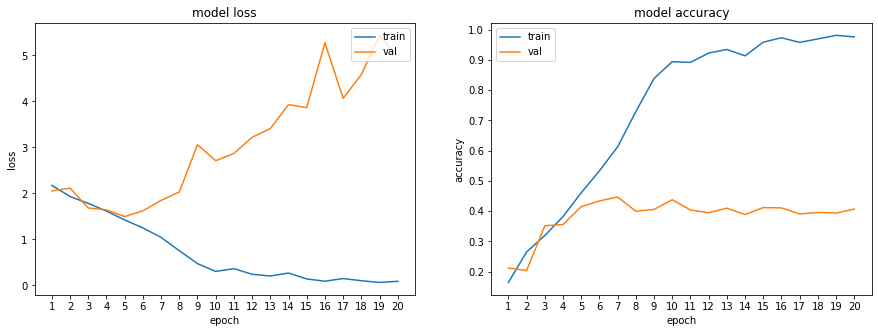

In [38]:
learning_plot(history,epochs)

### 作ったモデルを使い、test_imgsの画像へのラベル予測を行い、SIGNATEに投稿してみましょう
- 予測は`model.predict`関数を使います
- 予測結果はpred = [label1の確率, label2の確率, ..., label10の確率]と返ってきますが、label_idを1つに決める必要があります
- その為、`argmax(axis=1)`関数を使い、一番確率値が高いindexを取得します（indexはlabel_idと一致している為）

In [39]:
pred = model.predict(test_imgs)
pred

array([[3.80302589e-09, 1.04645835e-04, 5.83442072e-10, ...,
        2.46906581e-07, 4.22227594e-14, 1.02120756e-08],
       [4.05064884e-06, 7.59364222e-04, 6.62868551e-05, ...,
        5.86233549e-02, 5.87094801e-05, 1.30551009e-04],
       [6.61567226e-02, 2.79610902e-01, 7.41859083e-04, ...,
        9.16877668e-03, 2.18626913e-02, 7.73038939e-02],
       ...,
       [3.10453819e-03, 9.46696600e-05, 1.63356917e-09, ...,
        4.91962338e-09, 9.96800423e-01, 1.70409507e-07],
       [1.34324708e-07, 1.60271661e-14, 1.10679384e-05, ...,
        1.56164567e-12, 4.32912202e-05, 9.99945521e-01],
       [1.59415886e-01, 2.03885168e-01, 3.73791772e-05, ...,
        3.12943099e-04, 5.88035226e-01, 6.09929266e-05]], dtype=float32)

In [40]:
pred = pred.argmax(axis=1)
pred

array([6, 5, 5, ..., 8, 9, 8], dtype=int64)

In [41]:
sample[1] = pred
sample.to_csv("submit1.tsv", sep="\t", index=None, header=None)

### 演習②　今度はオプティマイザーをAdamに変更してモデルを学習し、予測結果をSIGNATEに投稿しましょう
- Adamを使う為には、`optimizer.Adam()`と記述します
- 投稿ファイルは`submit2.tsv`というファイル名で保存しましょう

In [42]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3,3), padding="same", input_shape=(96,96,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=120))
model.add(Activation("relu"))
model.add(Dense(units=60))
model.add(Activation("relu"))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [44]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=["accuracy"])

In [45]:
batch_size=100
epochs=20

In [46]:
history = model.fit(X_tr, y_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/20
40/40 [==============================] - 8s 191ms/step - loss: 2.1211 - accuracy: 0.2185 - val_loss: 1.8596 - val_accuracy: 0.3010
Epoch 2/20
40/40 [==============================] - 8s 205ms/step - loss: 1.6944 - accuracy: 0.3692 - val_loss: 1.7236 - val_accuracy: 0.3380
Epoch 3/20
40/40 [==============================] - 7s 169ms/step - loss: 1.5439 - accuracy: 0.4333 - val_loss: 1.5649 - val_accuracy: 0.4240
Epoch 4/20
40/40 [==============================] - 7s 166ms/step - loss: 1.4046 - accuracy: 0.4983 - val_loss: 1.5260 - val_accuracy: 0.4380
Epoch 5/20
40/40 [==============================] - 7s 170ms/step - loss: 1.3135 - accuracy: 0.5242 - val_loss: 1.5134 - val_accuracy: 0.4450
Epoch 6/20
40/40 [==============================] - 7s 178ms/step - loss: 1.1556 - accuracy: 0.5853 - val_loss: 1.4340 - val_accuracy: 0.4750
Epoch 7/20
40/40 [==============================] - 7s 181ms/step - loss: 1.0805 - accuracy: 0.6150 - val_loss: 1.4883 - val_accuracy: 0.4680
Epoch 

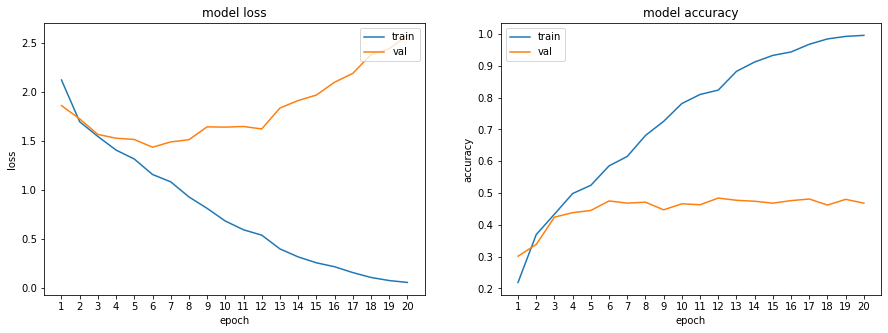

In [47]:
learning_plot(history,epochs)

In [48]:
pred = model.predict(test_imgs)
pred = pred.argmax(axis=1)
pred

array([5, 3, 5, ..., 0, 9, 0], dtype=int64)

In [49]:
sample[1] = pred
sample.to_csv("submit2.tsv", sep="\t", index=None, header=None)

### 演習③　層を１つ又は２つ程度追加し、精度を検証してみましょう
- 良いパラメータがあれば、SIGNATEにも投稿してみましょう
- filtersの値やkernel_sizeの値も変更してみましょう

In [50]:
model = Sequential()
model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same", input_shape=(96,96,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=24, kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=36, kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=120))
model.add(Activation("relu"))
model.add(Dense(units=60))
model.add(Activation("relu"))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 12)        336       
_________________________________________________________________
activation_23 (Activation)   (None, 96, 96, 12)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 12)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 24)        2616      
_________________________________________________________________
activation_24 (Activation)   (None, 48, 48, 24)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 24)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 36)       

In [52]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=["accuracy"])

In [53]:
batch_size=100
epochs=20

In [54]:
history = model.fit(X_tr, y_tr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/20
40/40 [==============================] - 12s 273ms/step - loss: 2.0920 - accuracy: 0.2192 - val_loss: 1.8270 - val_accuracy: 0.2860
Epoch 2/20
40/40 [==============================] - 10s 260ms/step - loss: 1.6844 - accuracy: 0.3688 - val_loss: 1.6539 - val_accuracy: 0.3790
Epoch 3/20
40/40 [==============================] - 10s 259ms/step - loss: 1.5390 - accuracy: 0.4293 - val_loss: 1.4774 - val_accuracy: 0.4420
Epoch 4/20
40/40 [==============================] - 10s 257ms/step - loss: 1.4217 - accuracy: 0.4750 - val_loss: 1.4605 - val_accuracy: 0.4700
Epoch 5/20
40/40 [==============================] - 10s 260ms/step - loss: 1.2896 - accuracy: 0.5390 - val_loss: 1.4040 - val_accuracy: 0.4820
Epoch 6/20
40/40 [==============================] - 10s 262ms/step - loss: 1.1795 - accuracy: 0.5757 - val_loss: 1.3313 - val_accuracy: 0.5010
Epoch 7/20
40/40 [==============================] - 10s 261ms/step - loss: 1.0859 - accuracy: 0.6173 - val_loss: 1.3658 - val_accuracy: 0.5030

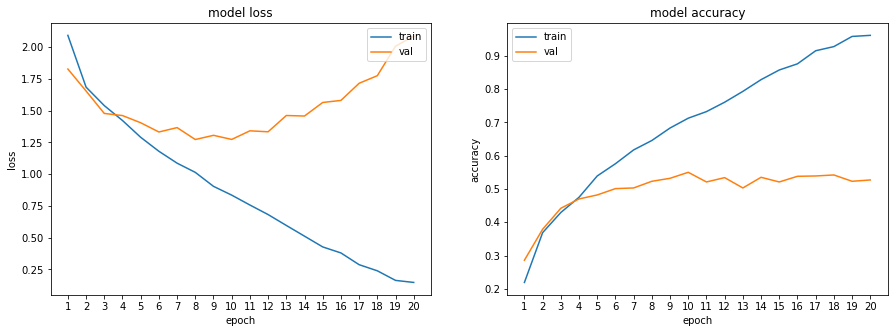

In [55]:
learning_plot(history,epochs)

In [56]:
pred = model.predict(test_imgs)
pred = pred.argmax(axis=1)
sample[1] = pred
sample.to_csv("submit3.tsv", sep="\t", index=None, header=None)

### 精度の検証をしてみよう
- 今回作成したモデルがどんな画像に対して当たっていて、どんな画像を外しているのかを確かめることも重要です
- 今回のようにラベル自体を出力結果とする時には混合行列を算出し、確かめることをします
- まず、検証用データに対する予測値を求め、sklearnのconfusion_matrix関数を使い、混合行列を求めます

In [57]:
pred = model.predict(X_val)
pred = pred.argmax(axis=1)

In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val.argmax(axis=1), pred)
cm

array([[85,  0,  3,  0,  0,  0,  1,  0,  6,  3],
       [14, 49,  0,  5, 15, 12,  5,  9,  4,  0],
       [ 2,  3, 78,  0,  2,  2,  1,  1,  6, 12],
       [ 1, 11,  2, 35, 20, 15,  6,  8,  1,  0],
       [ 1,  5,  0, 14, 60,  4, 11,  6,  0,  2],
       [ 1, 14,  0, 12, 13, 24, 13, 17,  0,  0],
       [ 2,  5,  0,  5, 11, 13, 45,  5,  0,  2],
       [ 2,  2,  1, 11, 16, 11, 14, 39,  1,  0],
       [13,  2,  7,  0,  2,  0,  0,  0, 66,  6],
       [12,  0, 27,  3,  0,  0,  5,  1, 11, 46]], dtype=int64)

- 続いて生成したconfusion_matrixを見やすくするためにヒートマップを描きます

In [59]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))
    ax.set_title(title, size=20)
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)
    ax.set_xticklabels(classes, fontsize=15)
    ax.set_yticklabels(classes, fontsize=15)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontsize=20,
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

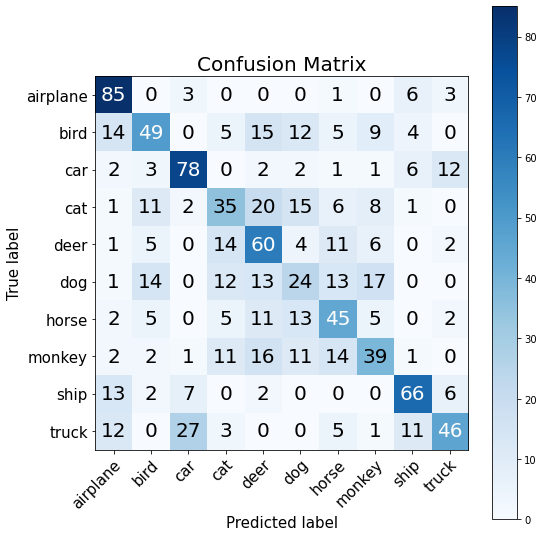

In [60]:
plot_confusion_matrix(cm, master["label_name"].values)
plt.show()

In [61]:
def plot_img(true_label, pred_label,pred,y_val):
    tmp = pd.DataFrame({"pred":pred,"true":y_val.argmax(axis=1)})
    tix = master[master["label_name"]==true_label]["label_id"].values[0]
    pix = master[master["label_name"]==pred_label]["label_id"].values[0]
    tmp = tmp[(tmp["pred"]==pix)&(tmp["true"]==tix)]
    
    if tmp.shape[0] > 0:    
        n = int(np.ceil(np.sqrt(tmp.shape[0])))
        fig = plt.figure(figsize=(n+5,n+5))
        fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)
        for i,v in enumerate(tmp.index):
            ax = fig.add_subplot(n, n, i + 1, xticks=[], yticks=[])
            ax.imshow(X_val[v])

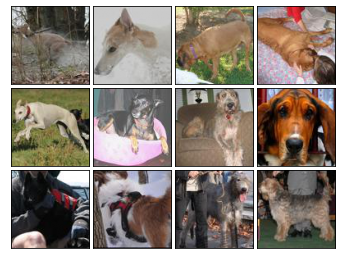

In [62]:
plot_img(true_label="dog", pred_label="cat", pred=pred, y_val=y_val)

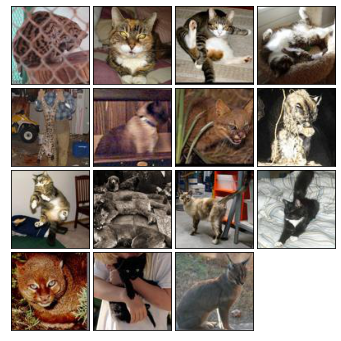

In [63]:
plot_img(true_label="cat", pred_label="dog", pred=pred, y_val=y_val)

### ラベル別の正解率を算出してみよう
- confusion_matrixを使えば、ラベル別に正解率を見ることもできます
- diagonal関数は対角成分（つまり各ラベルで正解した数）のみを抽出することができます
- 従って「ラベルの正解数÷ラベルの総数」により、各ラベルの正解率を求めることができます

In [64]:
acc = cm.diagonal()/cm.sum(axis=1)
ac1 = pd.DataFrame({"label":master["label_name"], "Accuracy":acc})
ac1

,label,Accuracy
0,airplane,0.867347
1,bird,0.433628
2,car,0.728972
3,cat,0.353535
4,deer,0.582524
5,dog,0.255319
6,horse,0.511364
7,monkey,0.402062
8,ship,0.687500
9,truck,0.438095


### モデルの保存の仕方とモデルの読み込み方について知ろう
- モデルはHDF5というファイルとして保存される為、拡張子は「.h5」とします
- 保存は`model.save()`、読み込みは`load_model()`を使います

In [65]:
file_path = 'my_model.h5'
model.save(file_path)

In [66]:
from keras.models import load_model

model = load_model(file_path)

## ▼更に精度向上を狙い、Data Augmentationを試してみよう
- Data Augmentationとはデータを水増しすることで、画像のパターンを増やして汎化性能を上げることを狙った手法を言います
- Data Augmentationは学習データに対する水増しと、予測データに対する水増しの2種類あります。
    - 後者はtest time augmentation（TTA）と呼ばれます
- 今回は前者の学習データに対する水増しの方法を学びましょう

### kerasのライブラリを使い、データ水増し器を作ろう
- scikit-image等を使いデータ水増しをすることもできますが、簡単な画像処理であればkerasに便利なライブラリ「ImageDataGenerator」があります

In [67]:
from keras.preprocessing.image import ImageDataGenerator

### ジェネレーターの使い方を学ぼう
- 基本的な画像操作の指定方法は下記です（より詳細は[こちら](https://keras.io/ja/preprocessing/image/)）
    1. 平行移動：height_shift_rangeとwidth_shift_rangeに平行移動させる割合（0.0-1.0）を設定する
    1. 反転：上下ならvertical_flip、左右ならhorizotal_flipをTrueにする
    1. 回転：rotation_rangeに最大回転角度の数値を設定する
    

- ジェネレーターの使い方は下記のようになります
    1. 画像操作の内容を指定したジェネレーターを宣言する
    1. flow関数を使い、iteratorを作る。その際、batch_sizeの指定が必要

In [68]:
img = train_imgs[1:2,]
batch_size = 1

# 平行移動
g1 = ImageDataGenerator(height_shift_range=0.5, width_shift_range=0.5)
i1 = g1.flow(img, batch_size=batch_size)

# 左右反転
g2 = ImageDataGenerator(horizontal_flip=True)
i2 = g2.flow(img, batch_size=batch_size)

# 回転
g3 = ImageDataGenerator(rotation_range=90)
i3 = g3.flow(img, batch_size=batch_size)

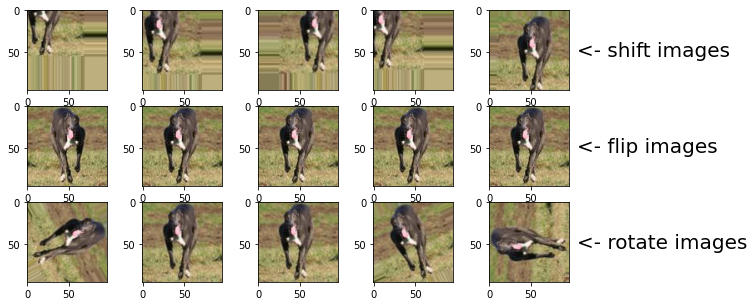

In [69]:
fig, ax = plt.subplots(3,5,figsize=(10,5))
i = 0
for a,b,c in zip(i1,i2,i3):
    if i > 4:
        break
    ax[0][i].imshow(a[0])
    ax[1][i].imshow(b[0])
    ax[2][i].imshow(c[0])
    i+=1
ax[0][4].text(105,55,"<- shift images",fontsize=20)
ax[1][4].text(105,55,"<- flip images",fontsize=20)
ax[2][4].text(105,55,"<- rotate images",fontsize=20)
plt.show()

### Data Augmentationを使い、モデルを学習しましょう

In [70]:
model = Sequential()
model.add(Conv2D(filters=12, kernel_size=(3,3), padding="same", input_shape=(96,96,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=24, kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=36, kernel_size=(3,3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=120))
model.add(Activation("relu"))
model.add(Dense(units=60))
model.add(Activation("relu"))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [71]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=["accuracy"])

In [72]:
batch_size=100
epochs=60

- Data AugumentationのGeneratorを生成
    - ここでは`height_shift_range=0.2, width_shift_range=0.2, horizontal_flip=True`とします

In [73]:
# 構築データ用のジェネレーター
datagen = ImageDataGenerator(height_shift_range=0.2, width_shift_range=0.2, horizontal_flip=True)
iterator = datagen.flow(X_tr, y_tr, batch_size=batch_size)

# 検証データ用のジェネレーター（特に何もしない）
datagen_val = ImageDataGenerator()
iterator_val = datagen_val.flow(X_val, y_val, batch_size=1, shuffle=False)

- Generatorを使い学習をする場合には、fit関数ではなく、fit_generator関数を代わりに使います
- この時、steps_per_epochを指定する必要がありますが、これは1epochあたり何ステップ実施するかを意味します
    - 通常はデータサイズ÷バッチサイズとします
    - batch_size=100ならば、1stepあたり100枚学習に使うことになるので、4000枚の学習画像全てを網羅する為には4000/100=40回必要になる為

In [74]:
history = model.fit_generator(generator=iterator, 
                              steps_per_epoch=len(X_tr)/batch_size, 
                              epochs=epochs, 
                              validation_data = iterator_val,
                              validation_steps = len(X_val))

C:\Users\takat\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
40/40 [==============================] - 22s 529ms/step - loss: 2.1501 - accuracy: 0.1890 - val_loss: 1.8448 - val_accuracy: 0.2940
Epoch 2/60
40/40 [==============================] - 20s 499ms/step - loss: 1.8204 - accuracy: 0.3033 - val_loss: 1.7622 - val_accuracy: 0.3490
Epoch 3/60
40/40 [==============================] - 22s 546ms/step - loss: 1.6975 - accuracy: 0.3553 - val_loss: 1.6709 - val_accuracy: 0.3810
Epoch 4/60
40/40 [==============================] - 23s 576ms/step - loss: 1.6586 - accuracy: 0.3713 - val_loss: 1.5336 - val_accuracy: 0.4280
Epoch 5/60
40/40 [==============================] - 25s 627ms/step - loss: 1.6181 - accuracy: 0.3832 - val_loss: 1.4929 - val_accuracy: 0.4550
Epoch 6/60
40/40 [==============================] - 21s 531ms/step - loss: 1.5742 - accuracy: 0.3985 - val_loss: 1.5104 - val_accuracy: 0.4140
Epoch 7/60
40/40 [==============================] - 23s 590ms/step - loss: 1.5605 - accuracy: 0.4137 - val_loss: 1.4230 - val_accuracy: 0.4550

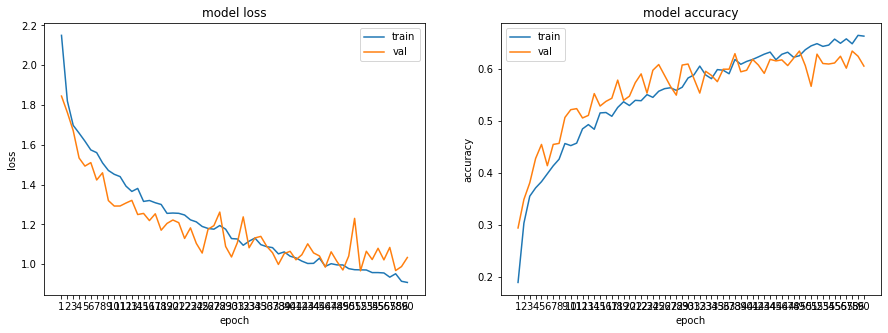

In [75]:
learning_plot(history,epochs)

### 精度の検証をしてみよう

In [76]:
pred = model.predict(X_val)
pred = pred.argmax(axis=1)
cm = confusion_matrix(y_val.argmax(axis=1), pred)

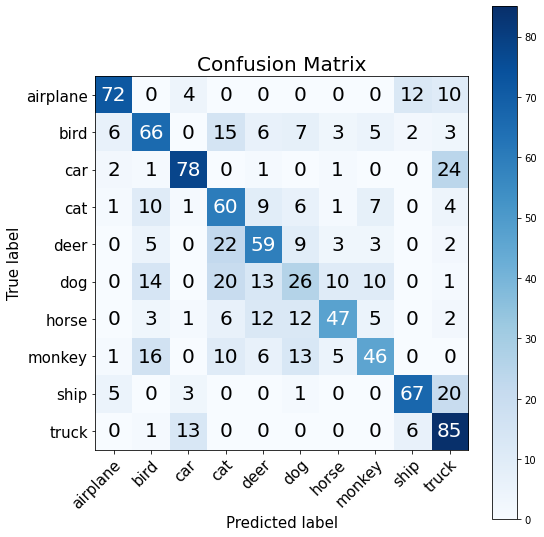

In [77]:
plot_confusion_matrix(cm, master["label_name"].values)
plt.show()

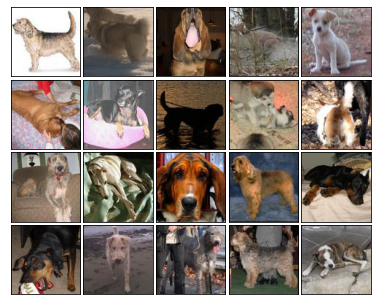

In [78]:
plot_img(true_label="dog", pred_label="cat", pred=pred, y_val=y_val)

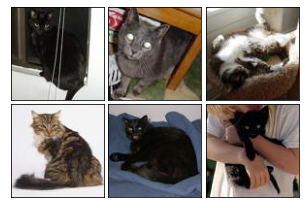

In [79]:
plot_img(true_label="cat", pred_label="dog", pred=pred, y_val=y_val)

In [80]:
acc = cm.diagonal()/cm.sum(axis=1)
ac2 = pd.DataFrame({"label":master["label_name"], "Accuracy":acc})
ac2

,label,Accuracy
0,airplane,0.734694
1,bird,0.584071
2,car,0.728972
3,cat,0.606061
4,deer,0.572816
5,dog,0.276596
6,horse,0.534091
7,monkey,0.474227
8,ship,0.697917
9,truck,0.809524


In [81]:
ac1

,label,Accuracy
0,airplane,0.867347
1,bird,0.433628
2,car,0.728972
3,cat,0.353535
4,deer,0.582524
5,dog,0.255319
6,horse,0.511364
7,monkey,0.402062
8,ship,0.687500
9,truck,0.438095


### 応募用ファイルを作り、SIGNATEに投稿してみよう

In [82]:
pred = model.predict(test_imgs)
pred = pred.argmax(axis=1)
sample[1] = pred
sample.to_csv("submit4.tsv", sep="\t", index=None, header=None)